In [111]:
import geopandas
import contextily as cx
import numpy as np
from shapely import geometry
import matplotlib.pyplot as plt

#### Variables

In [5]:
city = 'Cairo'
population =  21766883 # census 2021 data for 'Greater Cairo'
resolution = 500

In [ ]:
df = geopandas.read_file(city+".json")

##### Grid Class

In [106]:
# Produce a shapely POLYGON grid over a given area with a given meter resolution.
# Meant to be used to display density estimation within each grid cell.

class Grid:
    def __init__(self, resolution, population, datasets):\
        # List of GeoPanda Datasets
        self.data_list = datasets
        self.population = population
        self.grid = geopandas.GeoDataFrame()
        # Expected Pixel Resolution
        self.length = resolution
        self.xmin = None
        self.ymin = None
        self.xmax = None
        self.ymax = None
    
    def createGrid(self):
        total_bounds = self.data_list[0].to_crs('EPSG:3857').total_bounds
        self.xmin, self.ymin, self.xmax, self.ymax = total_bounds

        x, y = (self.xmin, self.ymin)
        array = []
        while y <= self.ymax:
            while x <= self.xmax:
                poly = geometry.Polygon([
                    (x,y), (x, y+self.length), 
                    (x+self.length, y+self.length), 
                    (x+self.length, y), (x, y)
                ])
                array.append([poly, self.population])
                x += self.length
            x = self.xmin
            y += self.length
            
        
        grid = geopandas.GeoDataFrame(array, columns=['geometry', 'population']).set_crs('EPSG:3857')
        self.grid = grid.to_crs('EPSG:4326')
        self.grid['population'] = self.grid['population'] / self.grid.size
        print(self.grid.head())
        return
    
    def plotPopulation(self):
        # Plots population density for now 
        ax = self.grid.plot(column='population', figsize=(15, 10), cmap='YlOrRd', alpha=0.5, legend=True)
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=self.grid.crs)
        
    

##### Plots

In [107]:
grid = Grid(500, population, [df])

In [108]:
grid.createGrid()

                                            geometry  population
0  POLYGON ((30.83297 29.75931, 30.83297 29.76321...  289.684363
1  POLYGON ((30.83746 29.75931, 30.83746 29.76321...  289.684363
2  POLYGON ((30.84195 29.75931, 30.84195 29.76321...  289.684363
3  POLYGON ((30.84644 29.75931, 30.84644 29.76321...  289.684363
4  POLYGON ((30.85094 29.75931, 30.85094 29.76321...  289.684363


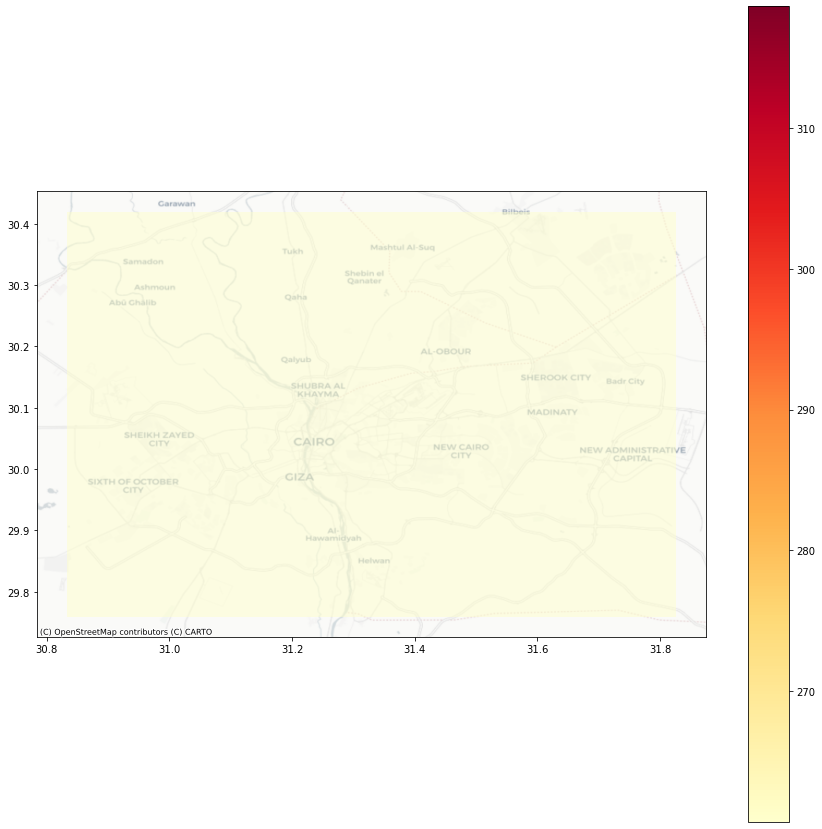

In [109]:
grid.plotPopulation()

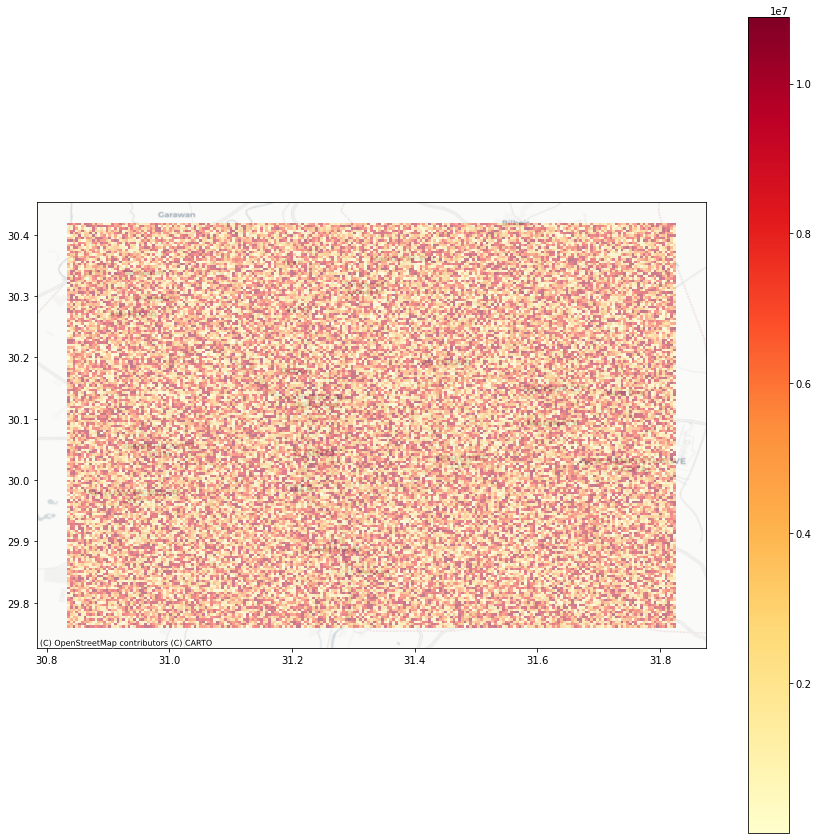

In [112]:
# Example for a grid with random distribution 

random_population = np.random.randint(0, egypt_population//2, size=grid.grid.size//2)
grid.grid['population'] = random_population
grid.plotPopulation()